In [54]:
# 필요 라이브러리 호출

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import calendar 
from datetime import datetime

import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Malgun Gothic' 
plt.rcParams["font.size"] = 10
%matplotlib inline 

In [253]:
# read datasets
train_raw = pd.read_csv("bike-sharing-demand/train.csv", index_col = 0, sep=',')
test_raw = pd.read_csv("bike-sharing-demand/test.csv", index_col = 0, sep=',')
submission = pd.read_csv("bike-sharing-demand/sampleSubmission.csv")

In [170]:
# train 확인
train_raw.head(2)

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81        0.0       3          13     16  
2011-01-01 01:00:00        80        0.0       8          32     40

In [171]:
# test 확인
test_raw.head(2)

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
2011-01-20 01:00:00       1        0           1        1  10.66  13.635   

                     humidity  windspeed  
datetime                                  
2011-01-20 00:00:00        56    26.0027  
2011-01-20 01:00:00        56     0.0000

In [172]:
# submission 확인
submission.head(2)

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0

## 데이터 파악 및 전처리
- 파생변수
- 상관관계
- dummy 변수

#### datetime 파생변수

In [173]:
def dateTimeVar(df):
    df1 = df.copy()
    # trainset, testset의 인덱스를 datetime으로 변환
    if not isinstance(df1.index[1], datetime):
        df1.index = pd.to_datetime(df1.index)
    
    # datetime을 사용한 파생변수
    # 연도, 월, 일, 요일, 시간
    df1['Yr'] = df1.index.year
    df1['Mth']= df1.index.month
    df1['Date']=df1.index.day
    df1['Day']=df1.index.weekday
    df1['hour']=df1.index.hour
    return df1

In [174]:
# train, test 적용
train = dateTimeVar(train_raw)
test=dateTimeVar(test_raw)

In [175]:
train.head(1) # 확인

season  holiday  workingday  weather  temp   atemp  humidity  \
datetime                                                                   
2011-01-01       1        0           0        1  9.84  14.395        81   

            windspeed  casual  registered  count    Yr  Mth  Date  Day  hour  
datetime                                                                      
2011-01-01        0.0       3          13     16  2011    1     1    5     0

In [178]:
test.columns # 확인

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'Yr', 'Mth', 'Date', 'Day', 'hour'],
      dtype='object')

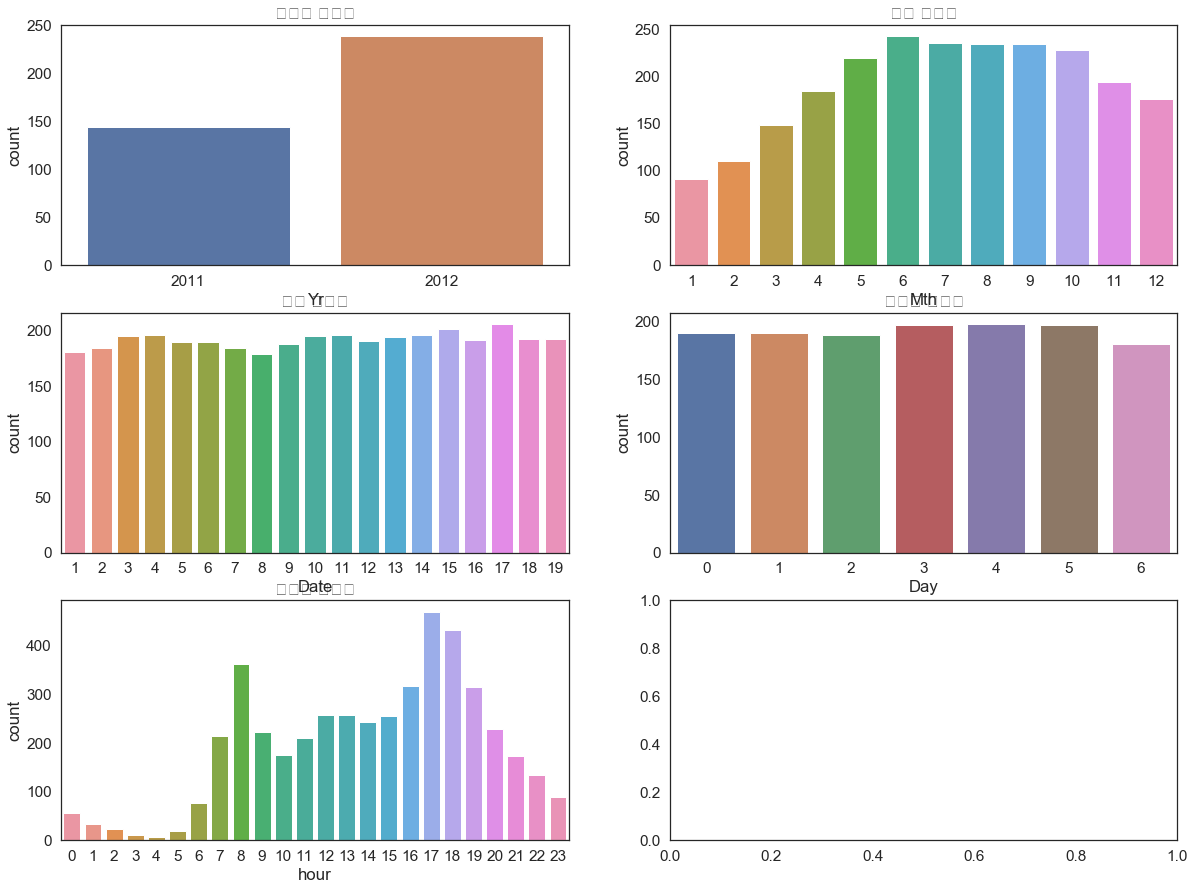

In [179]:
_, ax = plt.subplots(3,2, figsize=(20,15)) 

# 2012에 높은 카운트
a=sns.barplot(x='Yr',y='count',data=train.groupby('Yr')['count'].mean().reset_index(), ax=ax[0,0])
a.set_title('연도별 카운트')

# 1~5월 증가, 6월 peak, 7~9 높음, 10~12 감소
b = sns.barplot(x='Mth',y='count',data=train.groupby('Mth')['count'].mean().reset_index(), ax=ax[0,1])
b.set_title('월별 카운트')

# 평균적으로 3,10,17 일 경 높아지는데 이는 1주일(7일)간격이기에, 3,10,17일을 포함한 규칙적인 휴일(또는 목, 금요일)이 다수 있었을 거라 예상
c= sns.barplot(x='Date',y='count',data=train.groupby('Date')['count'].mean().reset_index(), ax=ax[1,0])
c.set_title('일별 카운트')

# 미약한 차이, 3,4 (목,금)요일이 높은 편
d = sns.barplot(x='Day',y='count',data=train.groupby('Day')['count'].mean().reset_index(), ax=ax[1,1])
d.set_title('요일별 카운트')

# 오전 8시(출근), 오후 17-18시(퇴근) 최대
e = sns.barplot(x='hour',y='count',data=train.groupby('hour')['count'].mean().reset_index(), ax=ax[2,0])
e.set_title('시간별 카운트')

plt.show()

#### season, holiday, workingday, weather 변수

In [181]:
# 주어진 데이터셋에서 season은 단순히 1~3, 4~6, 7~9, 10~12로 나누어져있따
# 이를 12~2: 겨울 (1), 3~5: 봄(2), 6~8: 여름(3), 9~11: 가을(4)로 바꾸어준다
train['season'] = train.Mth.apply(lambda x: 1 if x in [12,1,2] else 
                2 if x in [3,4,5] else 3 if x in [6,7,8]
               else 4)
test['season'] = test.Mth.apply(lambda x: 1 if x in [12,1,2] else 
                2 if x in [3,4,5] else 3 if x in [6,7,8]
               else 4)

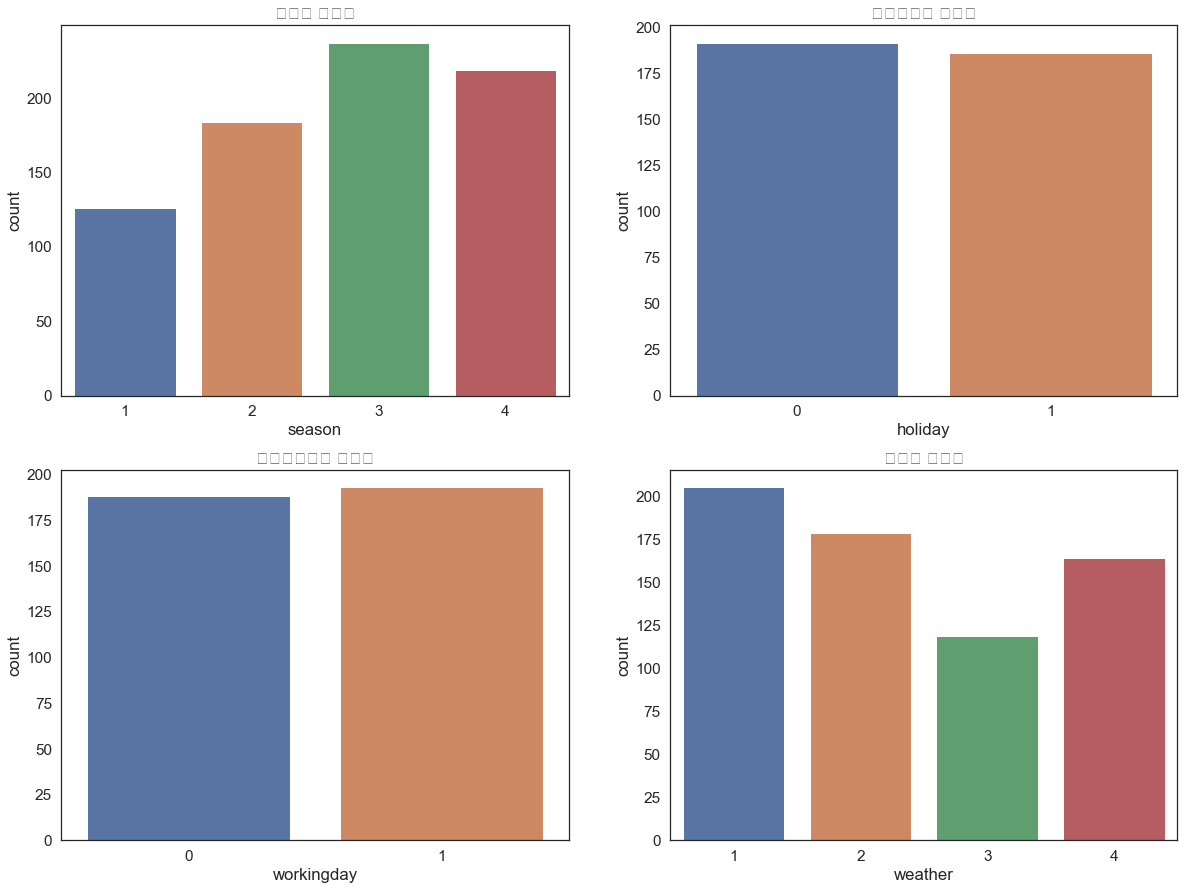

In [182]:
_, ax = plt.subplots(2,2, figsize=(20,15)) 

# 계절 3 (여름)에 가장 높음
a=sns.barplot(x='season',y='count',data=train.groupby('season')['count'].mean().reset_index(), ax=ax[0,0])
a.set_title('계절별 카운트')

# 큰 차이없으나 휴일이 아닐 때 좀 더 높은 편
# 자전거를 여가용보다 출퇴근용 등으로 사용하는 빈도가 조금 더 높은 듯
b = sns.barplot(x='holiday',y='count',data=train.groupby('holiday')['count'].mean().reset_index(), ax=ax[0,1])
b.set_title('휴일여부별 카운트')

# 위의 결과와 반대 (작업일일 때 조금 더 높다)
# holiday나 workingday 중 한 가지만 사용해도 될듯
c= sns.barplot(x='workingday',y='count',data=train.groupby('workingday')['count'].mean().reset_index(), ax=ax[1,0])
c.set_title('작업일여부별 카운트')

# weather: 1(맑음), 2(약간 구름), 3(약한 비), 4(폭우+우박+비폭풍+안개, 눈+안개 등)
# 1일 때 가장 높고 의외지만 4가 아닌 3에서 가장 낮음... 4일 때 예상외로 자전거를 많이 사용??
d = sns.barplot(x='weather',y='count',data=train.groupby('weather')['count'].mean().reset_index(), ax=ax[1,1])
d.set_title('날씨별 카운트')

plt.show()

#### heatmap 상관관계파악

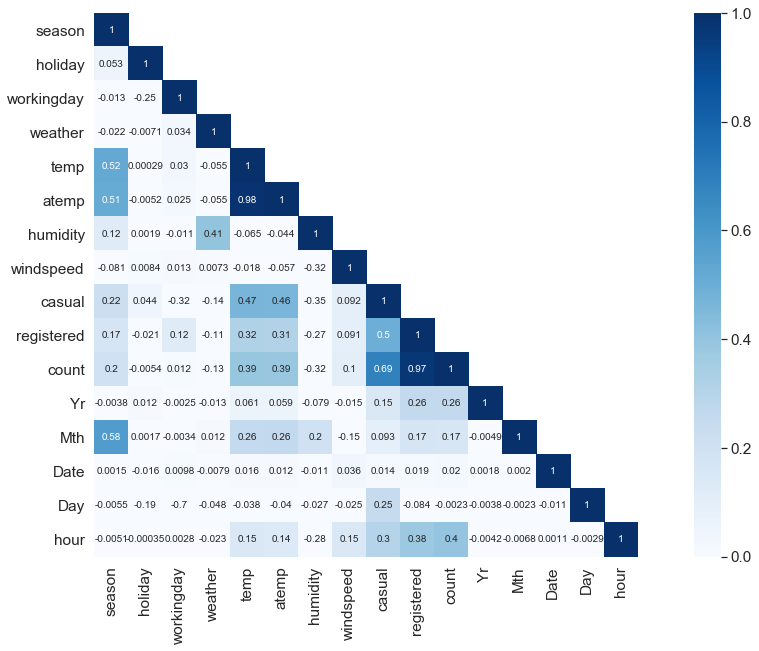

In [183]:
sns.set(font_scale=1.4)
sns.set_style("white")

corrMatt = train.corr()

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig,ax= plt.subplots()
fig.set_size_inches(20,10)

# count를 중점으로 볼 때, registered&casual은 당연히 높고 실제로 유의한 상관관계를 보이는 변수는
# hour, temp, atemp, Mth, Season, Yr 정도로 파악된다
sns.heatmap(corrMatt, mask=mask, vmax=1, vmin=0, square=True, 
            annot=True, cmap = 'Blues', annot_kws={"size": 10})

#### dummy 변수화(카테고리형 데이터, train, test 둘 다 진행)

**기본적으로 카테고리화할만큼 각 경우마다 차이가 충분히 보이는 경우에 dummy화 진행 (Day 등은 예상외로 차이가 크지 않아 우선 진행하지 않았다. 만일 후에 feature importance에서 충분히 중요하게 판명되면 재적용한다.)**

- Yr (2011, 2012)
- Mth (1~12)
- hour (0~23)
- season (1:겨울 ~ 4:가을)
- holiday 여부 (workingday drop)
- weather (1:맑음 ~ 4:아주 많은 비 등)

In [184]:
# 칼럼명 및 dummy변수화 할 데이터 확인
print(train.columns, '\n', test.columns)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'Yr', 'Mth',
       'Date', 'Day', 'hour'],
      dtype='object') 
 Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'Yr', 'Mth', 'Date', 'Day', 'hour'],
      dtype='object')


In [216]:
# dummy list 생성
dum_lst = ['season', 'holiday', 'weather', 'Yr','Mth', 'hour']

In [222]:
def dummies(df, dum_lst):
    df1 = df.copy()
    # dum_lst에 들어있는 각각의 변수마다 
    # tmp = get_dummies, 해당 original 변수는 drop
    # tmp와 변수가 drop된 df를 join 후 리턴
    for v in dum_lst:
        tmp = pd.get_dummies(df1[v], prefix=v)
        df1 = df1.drop(columns=v).join(tmp)
    return df1

In [225]:
# train, test 각각 dummy변수 진행
train_2 = dummies(train, dum_lst)
test_2 = dummies(test, dum_lst)

#### 사용하지 않을 칼럼 drop
- workingday
- registered, casual (test에 들어있지 않아 실제 예측에 사용할 수 없으며 어차피 최종 count만 필요하므로 제외) 

In [227]:
# 칼럼들 체크
print(train_2.columns, '\n', test_2.columns)

Index(['workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'Date', 'Day', 'season_1', 'season_2',
       'season_3', 'season_4', 'holiday_0', 'holiday_1', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'Yr_2011', 'Yr_2012', 'Mth_1',
       'Mth_2', 'Mth_3', 'Mth_4', 'Mth_5', 'Mth_6', 'Mth_7', 'Mth_8', 'Mth_9',
       'Mth_10', 'Mth_11', 'Mth_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'],
      dtype='object') 
 Index(['workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'Date', 'Day',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'Yr_2011', 'Yr_2012', 'Mth_1', 'Mth_2', 'Mth_3', 'Mth_4', 'Mth_

In [231]:
train_2 = train_2.drop(columns=['workingday','registered','casual'])
test_2 = test_2.drop(columns='workingday')

In [234]:
# 칼럼들 체크
print(train_2.columns, '\n', test_2.columns)
print(len(train_2.columns), len(test_2.columns))  # 이제 count 하나만 차이가 난다

Index(['temp', 'atemp', 'humidity', 'windspeed', 'count', 'Date', 'Day',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'Yr_2011', 'Yr_2012', 'Mth_1', 'Mth_2', 'Mth_3', 'Mth_4', 'Mth_5',
       'Mth_6', 'Mth_7', 'Mth_8', 'Mth_9', 'Mth_10', 'Mth_11', 'Mth_12',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object') 
 Index(['temp', 'atemp', 'humidity', 'windspeed', 'Date', 'Day', 'season_1',
       'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'Yr_2011',
       'Yr_2012', 'Mth_1', 'Mth_2', 'Mth_3', 'Mth_4', 'Mth_5', 'Mth_6',
       'Mth_7', 'Mth_8', 'Mth_9', 'Mth_10', 'M

## 모델링
#### 기준 
- linear regresion

#### 오차 계산
- RMSLE

#### 스코어 계산 데이터
- validation set

#### 회귀 모델 사용
- Gradient Boosting Regressor
- Random Forest Regressor
- GridSearchCV

In [329]:
# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

#### RMSLE

In [312]:
# y is predict value y_ is actual value
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#### Dataset 분할, Train, Valid, Test 생성

In [274]:
# full length of trainset
train_2.shape[0]

10886

In [275]:
# 80% of train data
train_2.shape[0]*0.80

8708.800000000001

In [279]:
# X_train, Y_train, X_test 생성
# 이 때 validation을 위한 셋을 따로 설정하여 
# fit(train) 후 predict(valid)로 score 계산, 괜찮은 경우 predict(test)로 진행
X_train = train_2[0:8708].drop(columns='count')  # 80%로 train진행
Y_train= train_2[0:8708]['count']

X_valid = train_2[8708:10886].drop(columns='count')
Y_valid= train_2[8708:10886]['count']

X_test = test_2
# 데이터셋 shape 확인
print(X_train.shape, Y_train.shape, 
      X_valid.shape, Y_valid.shape,
      X_test.shape)

(8708, 54) (8708,) (2178, 54) (2178,) (6493, 54)


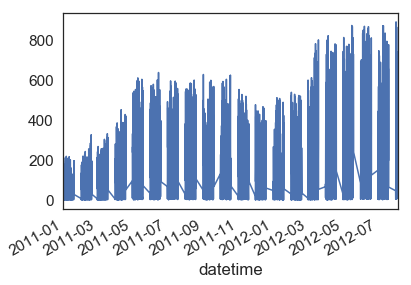

In [295]:
# Y_train 즉 count의 대략적 범위를 살펴본다
# 생각보다 차이가 큼 (~200 ~ 1000).
# 너무 차이가 많이 날 경우 오차가 커지므로 log화 한다
# 후에 값 비교시 다시 np.exp 진행
Y_train.plot()

In [296]:
Y_trainLog = np.log1p(Y_train)
Y_validLog = np.log1p(Y_valid)

#### 기준 모델 및 score 계산

In [297]:
# 넘어야 할 기준score를 위해 가장 단순한 linear regression 진행
model_lr = LinearRegression()
model_lr.fit(X_train, Y_trainLog)
valid_P_lr = model_lr.predict(X_valid)

# oh shit, 눈으로 봐도 어마무시한 차이,,,ㅋㅋㅋ
pd.DataFrame(list(zip(np.exp(valid_P_lr), np.exp(Y_validLog))), columns=['pred', 'real'])

pred   real
0      35.782309   20.0
1     116.334507   20.0
2     312.064482   69.0
3     611.384286  109.0
4     479.485778  230.0
5     343.473969  365.0
6     393.740770  438.0
7     480.327899  492.0
8     488.309041  524.0
9     474.246821  527.0
10    472.080852  451.0
11    582.355269  422.0
12    888.446549  383.0
13    400.484787  230.0
14    500.102578  186.0
15    376.616955  194.0
16    310.198723  209.0
17    244.635933  158.0
18    153.409616   88.0
19     75.418989   34.0
20     42.951467   12.0
21     25.457611    6.0
22      9.276442    6.0
23     11.553706   12.0
24     29.228297   26.0
25     91.378905  142.0
26    150.249701  408.0
27    469.630879  606.0
28    198.942239  277.0
29    264.647740  214.0
...          ...    ...
2148  531.139349  526.0
2149  391.147878  354.0
2150  262.151859  269.0
2151  210.490712  169.0
2152  169.281207  133.0
2153  114.658554   82.0
2154   62.498784   42.0
2155   33.511942   16.0
2156   20.669119    4.0
2157   11.503395    6.0
2158    8.131901    8.0
2159   22.856995   32.0
2160   71.965302  113.0
2161  190.301841  364.0
2162  344.250513  679.0
2163  266.914751  318.0
2164  208.346567  165.0
2165  263.113648  201.0
2166  314.627233  237.0
2167  322.216210  214.0
2168  297.034311  219.0
2169  308.367645  238.0
2170  394.221704  335.0
2171  589.237870  563.0
2172  538.664548  570.0
2173  398.540143  337.0
2174  274.334829  242.0
2175  200.677025  169.0
2176  171.394287  130.0
2177  109.995500   89.0

[2178 rows x 2 columns]

In [314]:
# 가장 단순한 linear regression 사용시 RMSE스코어
print('RMSE score_Linear Reg: ', 
      rmsle(valid_P_lr, Y_validLog, True))

RMSE score_Linear Reg:  0.5595713713962586


#### Advanced Modeling
- Gradient Boosting Regressor
- GridSearch+GBR 하려고 했으나 너무 오래 걸려서 미룸..ㅠㅜㅠ

In [333]:
# GBR model building
model_gb = GradientBoostingRegressor(max_depth=5, n_estimators=1000)
model_gb.fit(X_train, Y_trainLog)
valid_P_gb=model_gb1.predict(X_valid)

In [334]:
pd.DataFrame(list(zip(np.exp(valid_P_gb), np.exp(Y_validLog))), columns=['pred', 'real'])

pred   real
0      14.960030   20.0
1      20.594299   20.0
2      56.849233   69.0
3     142.758415  109.0
4     290.620859  230.0
5     387.671670  365.0
6     428.860140  438.0
7     527.756548  492.0
8     489.081882  524.0
9     492.781593  527.0
10    421.971255  451.0
11    538.244685  422.0
12    516.610235  383.0
13    314.460102  230.0
14    363.217985  186.0
15    321.273493  194.0
16    216.370231  209.0
17    185.049783  158.0
18     77.165887   88.0
19     45.190782   34.0
20     20.208222   12.0
21      9.121735    6.0
22      5.318709    6.0
23      8.337126   12.0
24     33.614779   26.0
25    166.579692  142.0
26    274.000745  408.0
27    735.496100  606.0
28    228.100688  277.0
29    196.018030  214.0
...          ...    ...
2148  440.107086  526.0
2149  321.340156  354.0
2150  206.703456  269.0
2151  159.629145  169.0
2152  113.543537  133.0
2153   64.504737   82.0
2154   23.062881   42.0
2155   11.400735   16.0
2156    6.787127    4.0
2157    5.144885    6.0
2158    4.270658    8.0
2159   26.264262   32.0
2160   98.669391  113.0
2161  295.437363  364.0
2162  511.289738  679.0
2163  298.880419  318.0
2164  136.607784  165.0
2165  167.256721  201.0
2166  188.622298  237.0
2167  188.925383  214.0
2168  160.791660  219.0
2169  173.579584  238.0
2170  248.033268  335.0
2171  360.117653  563.0
2172  414.007873  570.0
2173  302.684231  337.0
2174  234.129795  242.0
2175  163.429059  169.0
2176  147.836465  130.0
2177   59.310439   89.0

[2178 rows x 2 columns]

In [335]:
# 기준 스코어인 0.551957 보다 높다 (rmsle는 0에 가까울 수록 정확함)
print('RMSE score_Gradient Boosting Reg: ', 
      rmsle(valid_P_gb, Y_validLog, True))

RMSE score_Gradient Boosting Reg:  0.3603923928059495


In [336]:
# Test Prediction 진행
test_pred_gb = model_gb.predict(X_test)

In [337]:
# 확인
test_pred_gb

array([2.55548081, 1.76024029, 1.75048247, ..., 4.85620323, 4.56404591,
       3.86347001])

In [338]:
submission.head()

datetime      count
0  2011-01-20 00:00:00  16.016706
1  2011-01-20 01:00:00   7.219064
2  2011-01-20 02:00:00   5.146148
3  2011-01-20 03:00:00   4.472734
4  2011-01-20 04:00:00   3.311325

In [339]:
# submission 제출 및 점수확인 (0.42660)
submission['count'] = [max(0, x) for x in np.exp(test_pred_gb)]
submission.to_csv('result/gradient_boosting_sub.csv', index=False)

In [340]:
submission.head()

datetime      count
0  2011-01-20 00:00:00  12.877490
1  2011-01-20 01:00:00   5.813834
2  2011-01-20 02:00:00   5.757380
3  2011-01-20 03:00:00   5.254559
4  2011-01-20 04:00:00   2.523694

#### 시간이 오래걸려서 멈춘 GridSearch + GBR

In [308]:
# GridSearch on GBR 및 fit(train)
model_gb = GradientBoostingRegressor()
gb_param = {"loss":['ls', 'quantile'],
    "learning_rate": [0.01, 0.1],
    "max_depth":np.arange(3,8),
    "criterion": ["friedman_mse",  "mae"],
    "n_estimators":[100, 1000, 4000]
    }
grid_gb = GridSearchCV(model_gb, gb_param, cv=3)
grid_gb.fit(X_train, Y_trainLog)

KeyboardInterrupt: 

In [ ]:
# validation prediction
valid_P_GSgb = grid_gb.predict(X_valid)

#### RFReg

In [341]:
# Random Forest Regressor 도 사용해본다. 
model_rf = RandomForestRegressor(max_depth=5, n_estimators=1000)
model_rf.fit(X_train, Y_trainLog)
valid_P_rf = model_rf.predict(X_valid)

In [342]:
# 기준 스코어인 0.551957 보다 낮다ㅠㅠ 
# RF는 실패한 모델. 아마도 Grid Searching을 통해 parameter를 최적화하면 훨씬 좋아질것
print('RMSE score_Gradient Boosting Reg: ', 
      rmsle(valid_P_rf, Y_validLog, True))

RMSE score_Gradient Boosting Reg:  0.8736154396947907


In [343]:
train.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-19 14:00:00', '2012-12-19 15:00:00',
               '2012-12-19 16:00:00', '2012-12-19 17:00:00',
               '2012-12-19 18:00:00', '2012-12-19 19:00:00',
               '2012-12-19 20:00:00', '2012-12-19 21:00:00',
               '2012-12-19 22:00:00', '2012-12-19 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=10886, freq=None)

***

## 결론
- 2011.1월부터 2012.12월까지 1일부터 19일까지의 자전거대여 count 및 날씨 등의 자료를 활용하여 각각의 월마다 20~막일 까지의 count를 추측
- EDA과정에서 datetime을 활용한 파생변수(Yr, Mth, Date, Day, hour 등)을 생성하여 count 상관관계를 확인한 결과 Yr, Mth, Day 등이 유의한 관계를 가진다. 또한 temp, humidity, windspeed 등 날씨 관련 변수들도 관련이 있으므로 포함하여 진행. season, holiday 등의 변수도 상당히 유의한 관계를 가지므로 포함하여 진행한다. 이 중 카테고리화할 수 있는 변수들 중 correlation이 상당히 높았던 것으로 분석된 경우 get_dummies를 활용하여 더미변수화한다.
- 모델링시 rmsle스코어를 활용하였으며, linear regression을 기준으로 삼아 기타 모델을 비교하였다. Gradient Boosting Regressor이 가장 좋은 결과를 냈으며 GridSearching은 시간관계상 보류. Random Forest Regressor은 매우 낮은 결과를 내어 보류하였다.